# Chapter 3 - Classification

This notebook will be using the MNIST dataset. MNIST is a dataset of 70000 handwritten digits from the US census bureau and high school students all across the United States.   
This is a classic classifcation problem. Often times when new classification algorithms come out they are tested against this dataset to see how performant they are.   


In [1]:
# Luckily SKlearn has the dataset available

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
import pandas as pd   
import numpy as np 

pd.set_option('display.max_columns', 200)



X, y = mnist['data'], mnist['target']
y = y.astype('uint8')
print(f'X dtypes: {X.dtypes}')
print(f'y dtypes: {y.dtypes}')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

raw_data = pd.concat([X, y.to_frame()])



X dtypes: pixel1      float64
pixel2      float64
pixel3      float64
pixel4      float64
pixel5      float64
             ...   
pixel780    float64
pixel781    float64
pixel782    float64
pixel783    float64
pixel784    float64
Length: 784, dtype: object
y dtypes: uint8
X shape: (70000, 784)
y shape: (70000,)


## Checking out some of the data

<class 'pandas.core.frame.DataFrame'>
Expected result: 5


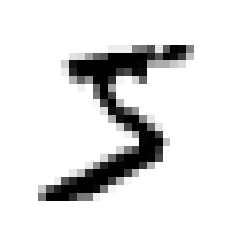

In [4]:
import matplotlib as mpl 

import matplotlib.pyplot as plt 

print(type(X))
print(f'Expected result: {y.iloc[0]}')
first_digit = X.iloc[0].to_numpy()
first_digit = first_digit.reshape(28, 28)
plt.imshow(first_digit, cmap='binary')
plt.axis('off')
plt.show()


## Train / Test split

Since the MNIST dataset is already so well studied the data has already been split into train and test for us and they have already done shuffling so that the data is good and will work with cross validation folds



In [5]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

y_train.dtypes

dtype('uint8')

In [6]:
y_train_5 = (y_train == 5.0)
y_test_5 = (y_test == 5.0)
print(f'X train shape: {X_train.shape}')
print(f'Y train 5 shape: {y_train_5.shape}')

X train shape: (60000, 784)
Y train 5 shape: (60000,)


In [7]:
y_train_5.unique()

array([ True, False])

## Trying out a stochastic classifier (SGDClassifier) The stochastic gradient descent classifier is a classifier that can handle large amounts of data it also relies on randomness during training

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state = 42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
first_5 = X_train.iloc[0].to_numpy().reshape(1, -1)
print(f'First 5 shape: {first_5.shape}')
print(y_train_5.iloc[0])

sgd_classifier.predict(first_5)

First 5 shape: (1, 784)
True


c:\Users\kpaga\OneDrive\Desktop\Desktop\VSProjects\PythonProjects\HANDS_ON_ML\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [10]:
predictions_train = sgd_classifier.predict(X_train)

In [11]:
from sklearn.metrics import accuracy_score

accuracy_score(predictions_train, y_train_5)

0.9522666666666667

Making an ensemble model with sgd_classifiers for each number




In [12]:


models = []
for i in range(10):
    
    data_y = (y_train == i)
    models.append(SGDClassifier(random_state=42).fit(X_train, data_y))



In [39]:


# Method to make predictions with 10 SGD classifiers one trained on each number.
# The method takes the last model to predict true. So, if two models predict true it chooses the higher number one
# Ensemble approach is kind of interesting here.
# Classifiers on each category combined 

def classifier_predict(X, models):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))
    
    results = np.full((len(predictions[0]), 1), -1)
    count = 0
    for prediction in predictions:
        
        for i in range(len(prediction)):
            
            if bool(prediction[i]) == True:
                
                results[i] = count
        count += 1
    return results




## Accuracy score is actually pretty bad with the SGDclassification ensemble method

Neural networks reach about 99% so this will not cut it. One also has to think about that roughly only 10% of the samples are the number the classifier is classifying,    
so a classifier that predicts not <insert number> will be right 90% of the time. This is a skewed dataset.


In [43]:
predictions = classifier_predict(X_train, models)
acc_score = accuracy_score(predictions, y_train)
print(f'Accuracy score on train data: {acc_score}')


predictions = classifier_predict(X_test, models)
acc_score = accuracy_score(predictions, y_test)
print(f'Accuracy score on test data: {acc_score}')


Accuracy score on train data: 0.75945
Accuracy score on test data: 0.7467


In [54]:
from sklearn.base import BaseEstimator

class never_5_estimator(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
        

In [55]:
from sklearn.model_selection import cross_val_score


never_5 = never_5_estimator()

cross_val_score(never_5, X_train, y_train, cv=3, scoring="accuracy")

array([0.0997 , 0.0965 , 0.09995])